# Electrophysiology example
How to insert electrodes and measure different spiking and extracellular signals.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from brian2 import *
import cleosim
from cleosim import *
# the default cython compilation target isn't worth it for 
# this trivial example
prefs.codegen.target = "numpy"
np.random.seed(1919)

## Network setup
First we create a toy E-I network with Poisson firing rates:

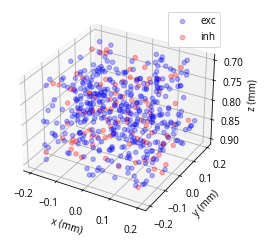

In [2]:
N = 500
n_e = int(N*.8)
n_i = int(N*.2)

exc = PoissonGroup(n_e, 10*Hz, name="exc")
inh = PoissonGroup(n_i, 30*Hz, name="inh")

net = Network([exc, inh])
sim = CLSimulator(net)

cleosim.coordinates.assign_coords_rand_rect_prism(exc, (-.2, .2), (-.2, .2), (0.7, 0.9))
cleosim.coordinates.assign_coords_rand_rect_prism(inh, (-.2, .2), (-.2, .2), (0.7, 0.9))
cleosim.coordinates.plot_neuron_positions(exc, inh, colors=['blue', 'red'])

## Electrode configuration

Now we insert an electrode shank probe in the center of the population by injecting an `ElectrodeGroup` device.
Note that `ElectrodeGroup` takes arbitrary coordinates as arguments, so you can place contacts wherever you wish.

Here we will use the convenience function `get_1D_probe_coords()` to generate coordinates as if we had a multi-channel shank probe. We specify a length of 1.2 mm and a channel count of 32. We could optionally set the base location and orientation, but by default the probe has its base at (0, 0, 0) and is pointing straight down.

We can add the electrode to the plotting function to visualize it:

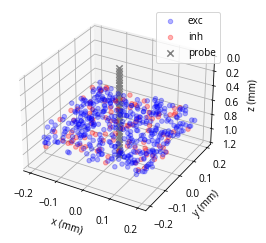

In [3]:
coords = cleosim.electrodes.linear_shank_coords(1.2 * mm, 32)
eg = cleosim.electrodes.ElectrodeGroup("probe", coords)
cleosim.coordinates.plot_neuron_positions(
    exc, inh, colors=["b", "r"], zlim=(0, 1.2), devices_to_plot=[eg]
)


This looks right, but we need to specify what signals we want to pick up with our electrode.
Let's try the two basic spiking signals and an LFP approximation for point neurons.

The two spiking signals (sorted and multi-unit) take the same parameters, mainly `perfect_detection_radius`, within which all spikes will be detected, and `half_detection_radius`, at which distance a spike has only a 50% chance of being detected. My choice to set these parameters at 50 and 100 μm is arbitary, though from [at least some published data](https://www.frontiersin.org/articles/10.3389/fnins.2019.00385/full#F4) that seems reasonable.

We use default parameters for the Teleńczuk kernel LFP approximation method (TKLFP), but will need to specify cell type (excitatory or inhibitory) and sampling period (if unavailable from a connected processing loop) upon injection.

In [4]:
mua = cleosim.electrodes.MultiUnitSpiking(
    "mua",
    perfect_detection_radius=0.05 * mm,
    half_detection_radius=0.1 * mm,
    save_history=True,
)
ss = cleosim.electrodes.SortedSpiking("ss", 0.05 * mm, 0.1 * mm, save_history=True)
tklfp = cleosim.electrodes.TKLFPSignal("tklfp", save_history=True)

eg.add_signals(mua, ss, tklfp)

from cleosim.processing import RecordOnlyProcessor
sim.set_processing_loop(RecordOnlyProcessor(sampling_period_ms=1))
sim.inject_recorder(eg, exc, tklfp_type="exc")
sim.inject_recorder(eg, inh, tklfp_type="inh")

# Simulation and results

Now we'll run the simulation:

In [5]:
sim.run(150*ms)

And plot the output of the three signals we've recorded:

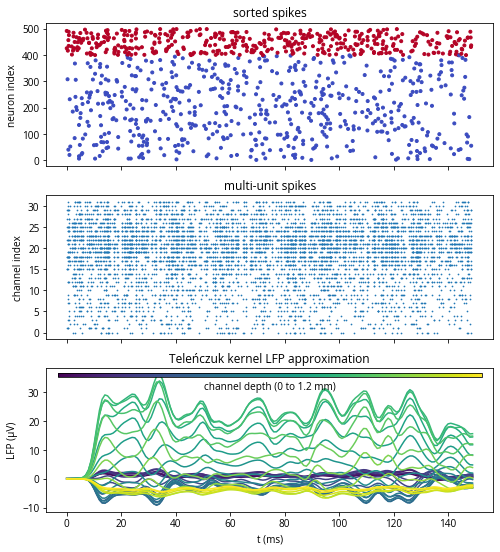

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

axs[0].scatter(ss.t_ms, ss.i, marker=".", c=ss.i >= n_e, cmap="coolwarm")
axs[0].set(title="sorted spikes", ylabel="neuron index")

axs[1].scatter(mua.t_ms, mua.i, marker=".", s=2)
axs[1].set(title="multi-unit spikes", ylabel="channel index")

lines = axs[2].plot(tklfp.lfp_uV)
axs[2].set(
    title="Teleńczuk kernel LFP approximation", xlabel="t (ms)", ylabel="LFP (μV)"
)

# color-code channel depth
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(axs[2], width='95%', height='3%', loc="upper center")
for i in range(32):
    l = lines[i]
    l.set_color(plt.cm.viridis(i / 31))
from matplotlib.colors import Normalize
channel_mappable = plt.cm.ScalarMappable(Normalize(0, 1.2), plt.cm.viridis)
fig.colorbar(
    channel_mappable,
    cax=axins,
    orientation="horizontal",
    ticks=[],
    label="channel depth (0 to 1.2 mm)",
);

Or, to see the LFP as a function of depth better:

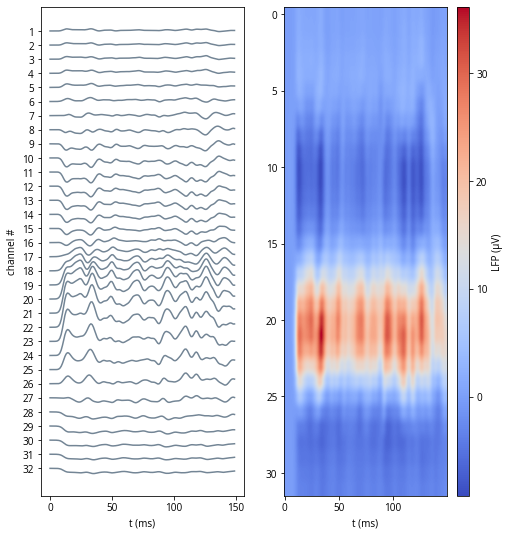

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 9))
channel_offsets = -12 * np.arange(32)
lfp_to_plot = tklfp.lfp_uV + channel_offsets
axs[0].plot(lfp_to_plot, color="xkcd:steel")
axs[0].set(
    yticks=channel_offsets,
    yticklabels=range(1, 33),
    xlabel="t (ms)",
    ylabel="channel #",
);
im = axs[1].imshow(tklfp.lfp_uV.T, aspect='auto', cmap='coolwarm')
axs[1].set(xlabel='t (ms)')
fig.colorbar(im, aspect=40, label='LFP (μV)');
